In [1]:
# dataset: Brain MRI segmentation
# reference: pytorch_brain_mri_segmentation_unet
# pytorch, UNet, Medical Image Segmentation

In [2]:
# load lib
import os
from skimage import io, transform

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
# load dataset
csv_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'
data_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

class Data(Dataset):
    def __init__(self, path):
        self.path = path
        # return list of all names of documents
        self.patients = [file for file in os.listdir(path) if file not in['data.csv', 'README.md']]
        self.masks, self.images = [],[]
        
        for patient in self.patients:
            for file in os.listdir(os.path.join(self.path, patient)):
                # .split('.')[0] = name of doc
                if 'mask' in file.split('.')[0].split('_'):
                    self.masks.append(os.path.join(self.path, patient, file))
                else:
                    self.images.append(os.path.join(self.path, patient, file))
                
        self.iamges = sorted(self.images)
        self.masks = sorted(self.masks)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # shape of image, mask = [3,256,256], [1,256,256]
        image = self.images[idx]
        mask = self.masks[idx]
        
        image = io.imread(image)  # read image
        image = transform.resize(image, (256, 256))
        image = image / 255  # normalization?
        image = image.transpose((2,0,1))  # pc, prec, FLAIR
        
        mask = io.imread(mask)
        mask = transform.resize(mask, (256, 256))
        mask = mask / 255
        mask = np.expand_dims(mask, axis=-1).transpose((2, 0, 1))
        # np.expand_dims(), expand the shape of array
        
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        
        return (image, mask)

In [4]:
data = Data(data_path)
# split the data to 3600train_set and 329validation_set
trainset, validset = random_split(data, [3600, 329])
train_loader = DataLoader(dataset=trainset, batch_size=10, shuffle=True)
valid_loader = DataLoader(dataset=validset, batch_size=10)

In [5]:
# visualization
def image_convert(image):
    # tensor->numpy
    # clone(): change idx, .cpu():move to cpu
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = image * 255
    return image

def mask_convert(mask):
    # tensor->numpy
    # .detach(): stop backward, np.squeeze: delete unidimension
    mask = mask.clone().cpu().detach().numpy()
    return np.squeeze(mask)

def plot_img(idx):
    iter_img = iter(train_loader)  # generate iterator
    images, masks = next(iter_img)  # get ele of iter
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figure=(20,10))
    for idxi in range(0, idx):
        image = image_convert(images[idxi])
        plt.subplot(2, idx, idxi+1)
        plt.imshow(image)
    for idxi in range(idx):
        masks = mask_convert(masks[idxi])
        plt.subplot(2, idx, idxi+idx+1)
        plt.imshow(mask, cmap='gray')
    plt.show()
    
# plot_img(idx)

In [6]:
# net
# ‘SAME’: padding = (kernel_size-stride)/2
class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Encoder, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.down = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        """
        : param x: input
        : return: out1(deep_layer),out2(next_layer)
        """
        out1 = self.layer(x)
        out2 = self.down(out1)    
        return out1, out2

    
class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Decoder, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
    def forward(self, x, out1):
        """
        : param x: input former layer
        : param out1: shallow layer
        """
        x = self.up(x)
        out = torch.cat((x, out1), dim=1)  # concatenation
        out = self.layer(out)
        return out
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        channels = [64, 128, 256, 512, 1024]
        
        # contract
        self.d1 = Encoder(3, channels[0])  # 3-64-64
        self.d2 = Encoder(channels[0], channels[1])  # 64-128-128
        self.d3 = Encoder(channels[1], channels[2])  # 128-256-256
        self.d4 = Encoder(channels[2], channels[3])  # 256-512-512
        
        # neck
        self.nk = nn.Sequential(
            nn.Conv2d(in_channels=channels[3], out_channels=channels[4],
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels[4]),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=channels[4], out_channels=channels[4],
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels[4]),
            nn.ReLU(inplace=True),
        )  # 512-1024-1024
        
        # expansive
        self.u4 = Decoder(channels[4]+channels[3], channels[3])  # 1024-512-512
        self.u3 = Decoder(channels[3]+channels[2], channels[2])  # 512+256-256-256
        self.u2 = Decoder(channels[2]+channels[1], channels[1])  # 256+128-128-128
        self.u1 = Decoder(channels[1]+channels[0], channels[0])  # 128+64-64-64
        
        # segmentation
        self.so = nn.Conv2d(in_channels=channels[0], out_channels=1,
                           kernel_size=1, stride=1, padding=0)  # 64-1
        
    def forward(self, x):
        outd1, out = self.d1(x)
        outd2, out = self.d2(out)
        outd3, out = self.d3(out)
        outd4, out = self.d4(out)
        
        out = self.nk(out)
        
        out = self.u4(out, outd4)
        out = self.u3(out, outd3)
        out = self.u2(out, outd2)
        out = self.u1(out, outd1)
        
        out = self.so(out)
        
        return out

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.7)

epochs, best_loss = 10, 1
train_loss, valid_loss = [], []
for epoch in range(epochs):
    model.train()
    temptrloss, tempvlloss = [], []
    print('Epoch {}/{}'.format(epoch+1, epochs))
    
    for image, mask in train_loader:
        image = image.to(device, dtype=torch.float)
        mask = mask.to(device, dtype=torch.float)
        pred = model.forward(image)
        mask, pred = torch.squeeze(mask), torch.squeeze(pred)
        loss = criterion(pred, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temptrloss.append(loss.item())
    
    else:
        with torch.no_grad():
            for image,mask in valid_loader:
                image = image.to(device, dtype=torch.float)
                mask = mask.to(device, dtype=torch.float)
                pred = model.forward(image)
                mask, pred = torch.squeeze(mask), torch.squeeze(pred)
                loss = criterion(pred, mask)
                tempvlloss.append(loss.item())
                
    etrloss = np.mean(temptrloss)
    print('Train loss:{}'.format(etrloss))
    train_loss.append(etrloss)
    evlloss = np.mean(tempvlloss)
    print('Validation loss:{}'.format(evlloss))
    valid_loss.append(evlloss)
    
    patience = 3
    if evlloss < best_loss:
        print(f'Best model found at epoch {epoch+1}, saving model')
        torch.save(model.state_dict(), 'segbrain_unet.pt')
        best_loss = evlloss
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f'No improvment {patience} consecutive epochs, break.')
            break

Epoch 1/10
Train loss:0.05682401858502999
Validation loss:0.04844827766558438
Best model found at epoch 1, saving model
Epoch 2/10
Train loss:0.055112714639593226
Validation loss:0.04743257888846777
Best model found at epoch 2, saving model
Epoch 3/10
Train loss:0.054202359127359365
Validation loss:0.04678865595523155
Best model found at epoch 3, saving model
Epoch 4/10
Train loss:0.05356573782951778
Validation loss:0.046372588498122765
Best model found at epoch 4, saving model
Epoch 5/10
Train loss:0.05304475119531465
Validation loss:0.046064061084479996
Best model found at epoch 5, saving model
Epoch 6/10
Train loss:0.052603276233680336
Validation loss:0.045859470765924816
Best model found at epoch 6, saving model
Epoch 7/10
Train loss:0.05227765735584803
Validation loss:0.04569968911395832
Best model found at epoch 7, saving model
Epoch 8/10
Train loss:0.051962192949253624
Validation loss:0.04558115595048576
Best model found at epoch 8, saving model
Epoch 9/10
Train loss:0.051655406

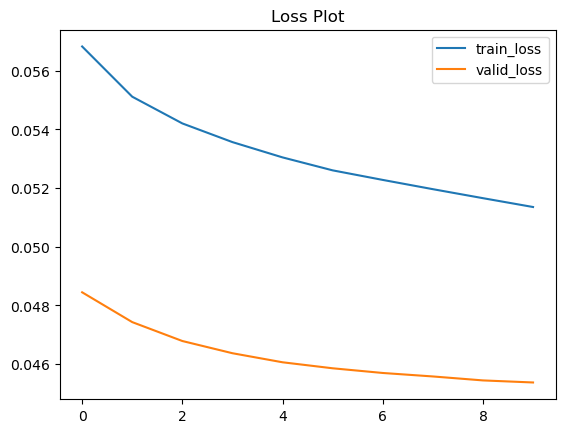

In [8]:
plt.plot(train_loss,label='train_loss')
plt.plot(valid_loss,label='valid_loss')
plt.legend()
plt.title('Loss Plot')
plt.show()